In [10]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

import matplotlib.pyplot as plt
import joblib
import seaborn as sns

# For predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

print("Library imported")

Library imported


In [11]:
# Load dataset Symptomp severity
df_severity = pd.read_csv("dataset/Symptom-severity.csv")

# Load dataset Symptomp precaution
df_precaution = pd.read_csv("dataset/symptom_precaution.csv")

# Load dataset Symptomp description
df_description = pd.read_csv("dataset/symptom_Description.csv")

# Load dataset
df_dataset = pd.read_csv("dataset/dataset.csv")

print("Dataset loaded")

Dataset loaded


In [12]:
print("\n First 5 rows severity data")
print(df_severity.head())

print("\n First 5 rows precaution data")
print(df_precaution.head())

print("\n First 5 rows description data")
print(df_description.head())

print("\n First 5 rows dataset data")
print(df_dataset.head())


 First 5 rows severity data
                Symptom  weight
0               itching       1
1             skin_rash       3
2  nodal_skin_eruptions       4
3   continuous_sneezing       4
4             shivering       5

 First 5 rows precaution data
          Disease                      Precaution_1  \
0   Drug Reaction                   stop irritation   
1         Malaria          Consult nearest hospital   
2         Allergy                    apply calamine   
3  Hypothyroidism                     reduce stress   
4       Psoriasis  wash hands with warm soapy water   

                   Precaution_2        Precaution_3  \
0      consult nearest hospital    stop taking drug   
1               avoid oily food  avoid non veg food   
2       cover area with bandage                 NaN   
3                      exercise         eat healthy   
4  stop bleeding using pressure      consult doctor   

                  Precaution_4  
0                    follow up  
1           keep mos

In [13]:
print('Missing values in Symptom Severity Data:')
print(df_severity.isna().sum())

print('\nMissing values in Symptom Description Data:')
print(df_description.isna().sum())

print('\nMissing values in Symptom Precaution Data:')
print(df_precaution.isna().sum())

print('\nMissing values in Main Disease-Symptom Dataset:')
print(df_dataset.isna().sum())

Missing values in Symptom Severity Data:
Symptom    0
weight     0
dtype: int64

Missing values in Symptom Description Data:
Disease        0
Description    0
dtype: int64

Missing values in Symptom Precaution Data:
Disease         0
Precaution_1    0
Precaution_2    0
Precaution_3    1
Precaution_4    1
dtype: int64

Missing values in Main Disease-Symptom Dataset:
Disease          0
Symptom_1        0
Symptom_2        0
Symptom_3        0
Symptom_4      348
Symptom_5     1206
Symptom_6     1986
Symptom_7     2652
Symptom_8     2976
Symptom_9     3228
Symptom_10    3408
Symptom_11    3726
Symptom_12    4176
Symptom_13    4416
Symptom_14    4614
Symptom_15    4680
Symptom_16    4728
Symptom_17    4848
dtype: int64


In [14]:
# Preprocessing dataset and data severity

# Cleaning severity data
df_severity["Symptom"] = df_severity["Symptom"].str.lower().str.strip().str.replace(r"\s+", "_", regex=True)
df_severity_map = dict(zip(df_severity["Symptom"], df_severity["weight"]))

# Cleaning dataset
df_dataset.fillna("", inplace=True)
symptom_cols = [col for col in df_dataset.columns if col.startswith("Symptom")]

# Clean symptom values in dataset
for col in symptom_cols:
    df_dataset[col] = (
        df_dataset[col].astype(str)
        .str.lower()
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
    )

# Build full symptom list
all_symptoms = sorted({s for s in pd.unique(df_dataset[symptom_cols].values.ravel()) if s != ""})
print(f"Total unique symptoms: {len(all_symptoms)}")
print(f"Unique symptoms: {all_symptoms}")

unknown_symptoms = [s for s in all_symptoms if s not in df_severity_map and s != ""]
print(f"Unknown symptoms: {unknown_symptoms}")

def row_to_vector(row):
    vector = [0] * len(all_symptoms)
    for symptom in row:
        if symptom in df_severity_map:
            idx = all_symptoms.index(symptom)
            vector[idx] = df_severity_map[symptom]
    return vector

# Prepare features and labels
X = df_dataset[symptom_cols].apply(row_to_vector, axis=1, result_type="expand")
y = df_dataset["Disease"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

Total unique symptoms: 131
Unique symptoms: ['abdominal_pain', 'abnormal_menstruation', 'acidity', 'acute_liver_failure', 'altered_sensorium', 'anxiety', 'back_pain', 'belly_pain', 'blackheads', 'bladder_discomfort', 'blister', 'blood_in_sputum', 'bloody_stool', 'blurred_and_distorted_vision', 'breathlessness', 'brittle_nails', 'bruising', 'burning_micturition', 'chest_pain', 'chills', 'cold_hands_and_feets', 'coma', 'congestion', 'constipation', 'continuous_feel_of_urine', 'continuous_sneezing', 'cough', 'cramps', 'dark_urine', 'dehydration', 'depression', 'diarrhoea', 'dischromic__patches', 'distention_of_abdomen', 'dizziness', 'drying_and_tingling_lips', 'enlarged_thyroid', 'excessive_hunger', 'extra_marital_contacts', 'family_history', 'fast_heart_rate', 'fatigue', 'fluid_overload', 'foul_smell_of_urine', 'headache', 'high_fever', 'hip_joint_pain', 'history_of_alcohol_consumption', 'increased_appetite', 'indigestion', 'inflammatory_nails', 'internal_itching', 'irregular_sugar_level

In [15]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Save model + label encoder
joblib.dump(model, "output/model.pkl")
joblib.dump(le, "output/label_encoder.pkl")
joblib.dump(all_symptoms, "output/symptom_list.pkl")
joblib.dump(df_severity_map, "output/severity_map.pkl")

['output/severity_map.pkl']

In [16]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate prediction accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Prediction Accuracy:', accuracy)

print("\n")

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Prediction Accuracy: 1.0


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        26
           9       1.00      1.00      1.00        23
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00        27
          12       1.00      1.00      1.00        25
          13       1.00      1.00      1.00        18
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        29
          16       1.00      1.

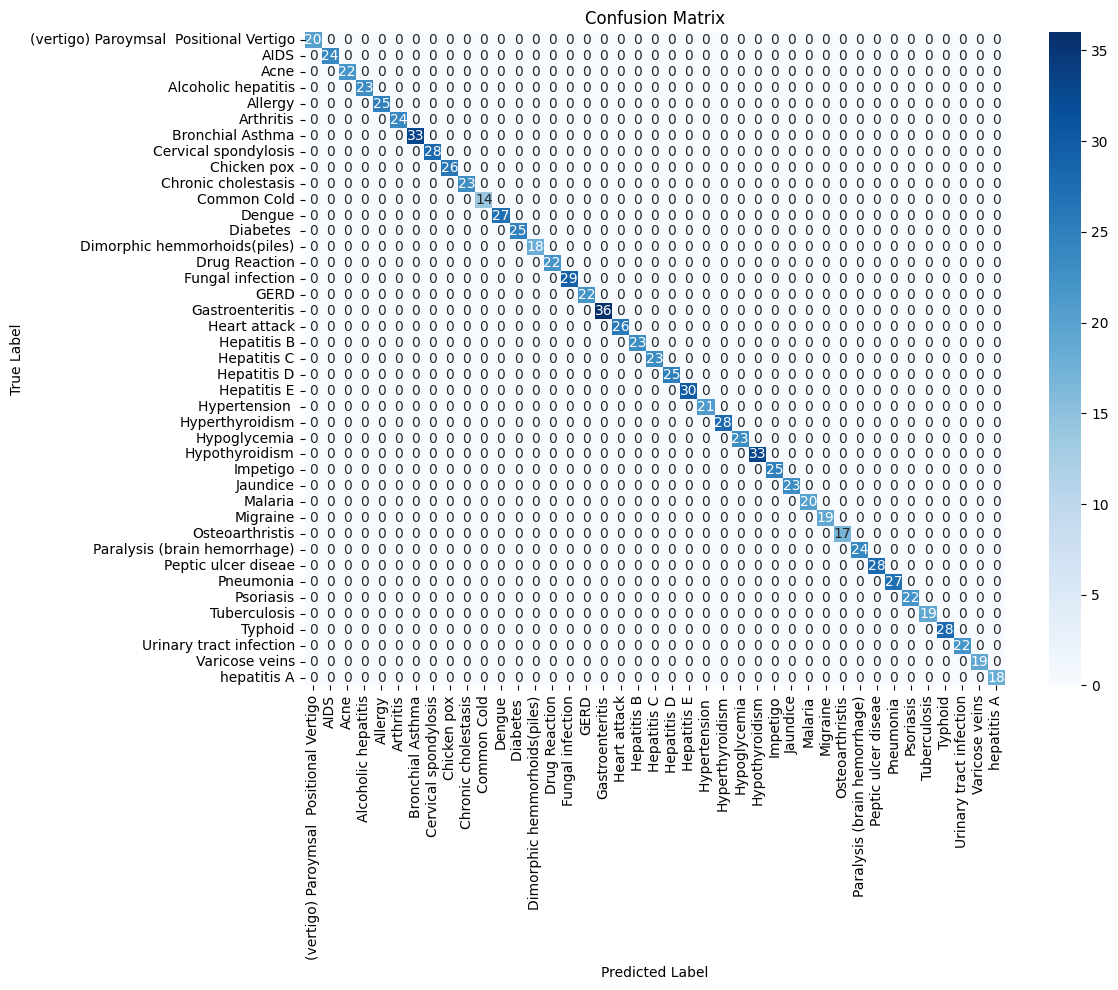

In [17]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

labels = le.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()